In [ ]:
!wget --no-check-certificate \
      https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv

--2020-11-19 03:24:15--  https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv
Resolving www.gstatic.com (www.gstatic.com)... 172.217.204.94, 2607:f8b0:400c:c12::5e
Connecting to www.gstatic.com (www.gstatic.com)|172.217.204.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220055340 (210M) [text/csv]
Saving to: ‘Global_Mobility_Report.csv’

Global_Mobility_Rep 100%[===================>] 209.86M  37.5MB/s    in 6.2s    

2020-11-19 03:24:21 (34.1 MB/s) - ‘Global_Mobility_Report.csv’ saved [220055340/220055340]



In [6]:
!wget --no-check-certificate \
      https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv

--2020-11-19 03:45:31--  https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2858110 (2.7M) [text/plain]
Saving to: ‘time-series-19-covid-combined.csv’

time-series-19-covi 100%[===================>]   2.73M  --.-KB/s    in 0.1s    

2020-11-19 03:45:32 (25.7 MB/s) - ‘time-series-19-covid-combined.csv’ saved [2858110/2858110]



In [9]:
from oauth2client.client import GoogleCredentials
from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from google.colab import auth
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()
import datetime
import csv

mobility_data = pd.read_csv('/content/Global_Mobility_Report.csv', low_memory=False)
mobility_data = mobility_data.drop(columns=['country_region_code','iso_3166_2_code','census_fips_code'], axis=1)
mobility_data.columns = ['Country/Region', 'sub_region_1','sub_region_2','metro_area','Date', 'Retail_Recreation', 'Grocery_Pharmacy', 'Parks', 'Transit_Stations', 'Workplaces', 'Residential']
mobility_data = mobility_data.set_index('Date')
mobility_data.index = pd.to_datetime(mobility_data.index)

covid_data = pd.read_csv('/content/time-series-19-covid-combined.csv', low_memory=False)
covid_data = covid_data.set_index('Date')
covid_data.index = pd.to_datetime(covid_data.index)

def takecovid(filename):
  with open(filename,'r', encoding='utf8') as file_csv:
    reader = pd.read_csv(file_csv)
  df = pd.DataFrame(reader)
  df = df.drop(columns=['Province/State','Lat','Long'], axis=1)

  df = df.set_index('Date')
  df.index = pd.to_datetime(df.index)

  return df

def mobility_country(country) :
  new_mobility_data = mobility_data.loc[mobility_data['Country/Region']== country]
  new_mobility_data = new_mobility_data[new_mobility_data['sub_region_1'].isnull()] 
  new_mobility_data = new_mobility_data[new_mobility_data['sub_region_2'].isnull()]
  new_mobility_data = new_mobility_data[new_mobility_data['metro_area'].isnull()]
  new_mobility_data = new_mobility_data.loc['2020-2-15' : '2020-7-31']
  print (new_mobility_data)
  # new_mobility_data = new_mobility_data[np.logical_and.reduce([new_mobility_data.index >= '2020-02-15', new_mobility_data.index <= '2020-7-31'])] #samaaja

  mobility_data_country = new_mobility_data.drop(columns=['sub_region_1','sub_region_2','metro_area'], axis=1)

  return mobility_data_country

def covid_country(country, data) : 
  new_covid_data = data.loc[data["Country/Region"] == country]
  # new_covid_data = new_covid_data.drop(columns=['Province/State','Lat','Long'], axis=1)
  # new_covid_data["Confirmed"] = new_covid_data["Confirmed"].diff()
  # new_covid_data["Recovered"] = new_covid_data["Recovered"].diff()
  # new_covid_data["Deaths"] = new_covid_data["Deaths"].diff()
  new_covid_data = new_covid_data.loc['2020-2-22' : '2020-8-7']
  
  return new_covid_data

def plotter(country, judul) :
  country.resample('1W').mean().plot(title=judul, marker='o', figsize=(20,10), fontsize=10, x_compat=True)
  # country.plot(title=judul, marker='o', figsize=(20,10), fontsize=10, x_compat=True)
  plt.xlabel('Month', fontsize=10)
  plt.ylabel('Percent change', fontsize=10)

def correlation(data_mobility, data_covid, country) :
  new_data_mobility = data_mobility.drop(columns=['Country/Region'], axis=1)
  new_data_mobility = new_data_mobility.loc[~new_data_mobility.index.duplicated(keep='first')]
  new_data_covid = data_covid.drop(columns=['Country/Region'], axis=1)
  new_data_covid = new_data_covid.loc[~new_data_covid.index.duplicated(keep='first')]

  correlationMatrix = pd.concat([new_data_mobility, new_data_covid], axis=1).corr(method='pearson')

  fig, axes = plt.subplots(figsize=(20,10))
  heatmapResult = sns.heatmap(correlationMatrix, cmap='coolwarm', annot=True, annot_kws={'size':10}, fmt=".7f", ax=axes)
  heatmapResult.set_xticklabels(heatmapResult.get_xticklabels(), rotation=45)
  heatmapResult.set_yticklabels(heatmapResult.get_yticklabels(), rotation=45)
  axes.set_title(country)
  plt.show()

  # pval = np.zeros([new_data_mobility.shape[1],new_data_covid.shape[1]])
  # for i in range(new_data_mobility.shape[1]): # rows are the number of rows in the matrix.
  #   for j in range(new_data_covid.shape[1]):
  #       JonI        = pd.ols(y=new_data_mobility, x=new_data_covid, intercept=True)
  #       pval[i,j]  = JonI.f_stat['p-value']

In [ ]:
# data_covid = takecovid('/content/owid-covid-data.csv')

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15         Russia          NaN  ...        1.0        -1.0
2020-02-16         Russia          NaN  ...        3.0         0.0
2020-02-17         Russia          NaN  ...        1.0         1.0
2020-02-18         Russia          NaN  ...        2.0         0.0
2020-02-19         Russia          NaN  ...        2.0         0.0
...                   ...          ...  ...        ...         ...
2020-07-27         Russia          NaN  ...      -28.0         0.0
2020-07-28         Russia          NaN  ...      -27.0         0.0
2020-07-29         Russia          NaN  ...      -27.0        -1.0
2020-07-30         Russia          NaN  ...      -28.0        -1.0
2020-07-31         Russia          NaN  ...      -31.0         0.0

[168 rows x 10 columns]


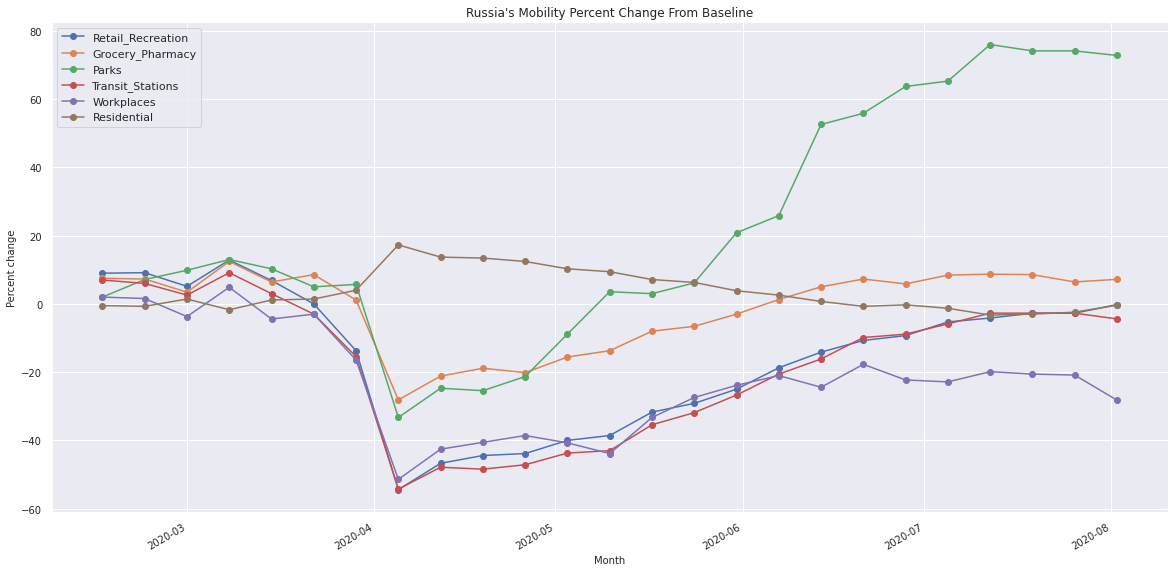

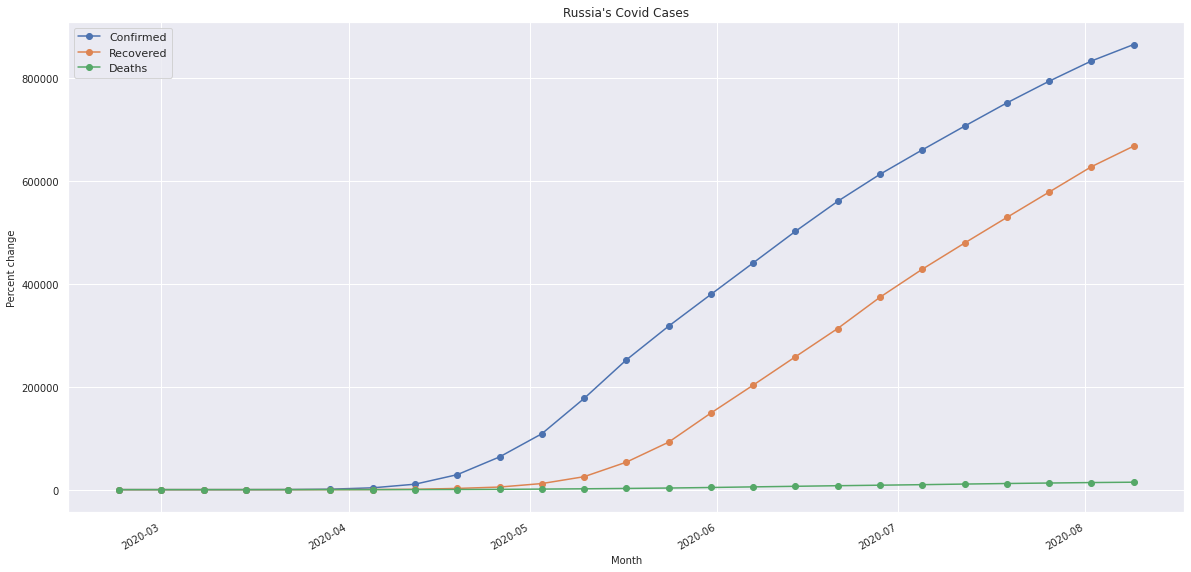

In [10]:
#North Subtropical
#Russia
mobility_data_russia = mobility_country('Russia')
covid_data_russia = covid_country('Russia', covid_data)
plotter(mobility_data_russia, "Russia's Mobility Percent Change From Baseline")
plotter(covid_data_russia, "Russia's Covid Cases")

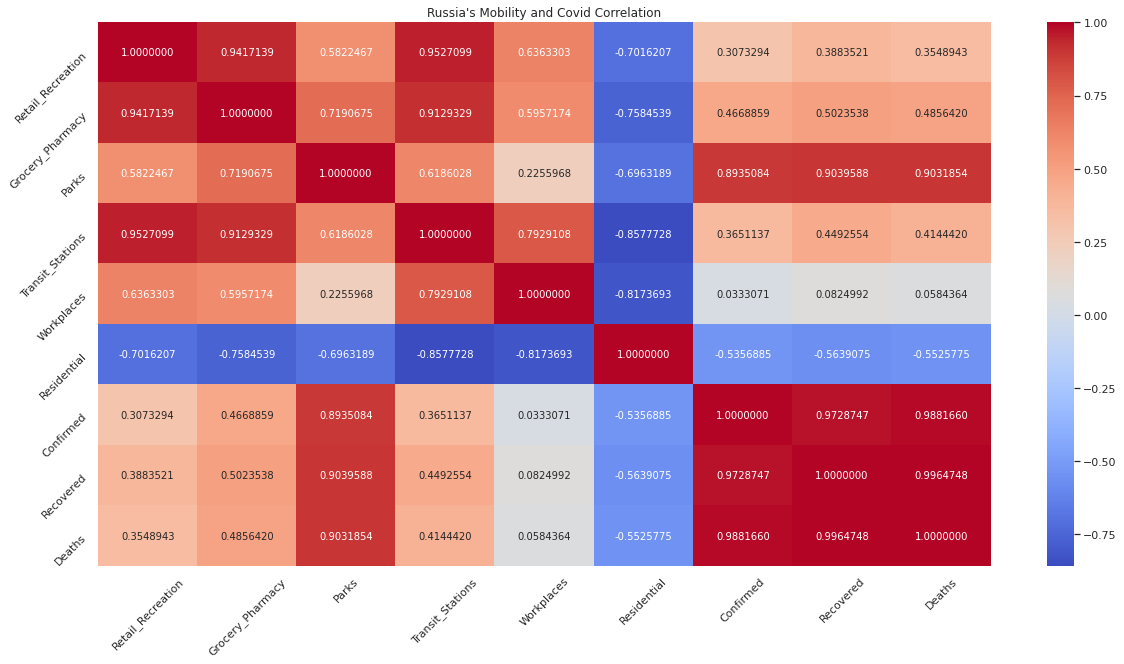

In [11]:
correlation(mobility_data_russia, covid_data_russia, "Russia's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15          Italy          NaN  ...        0.0        -1.0
2020-02-16          Italy          NaN  ...        1.0        -2.0
2020-02-17          Italy          NaN  ...        1.0         0.0
2020-02-18          Italy          NaN  ...        1.0         0.0
2020-02-19          Italy          NaN  ...        1.0         0.0
...                   ...          ...  ...        ...         ...
2020-07-27          Italy          NaN  ...      -27.0         1.0
2020-07-28          Italy          NaN  ...      -26.0         2.0
2020-07-29          Italy          NaN  ...      -26.0         2.0
2020-07-30          Italy          NaN  ...      -27.0         2.0
2020-07-31          Italy          NaN  ...      -28.0         1.0

[168 rows x 10 columns]


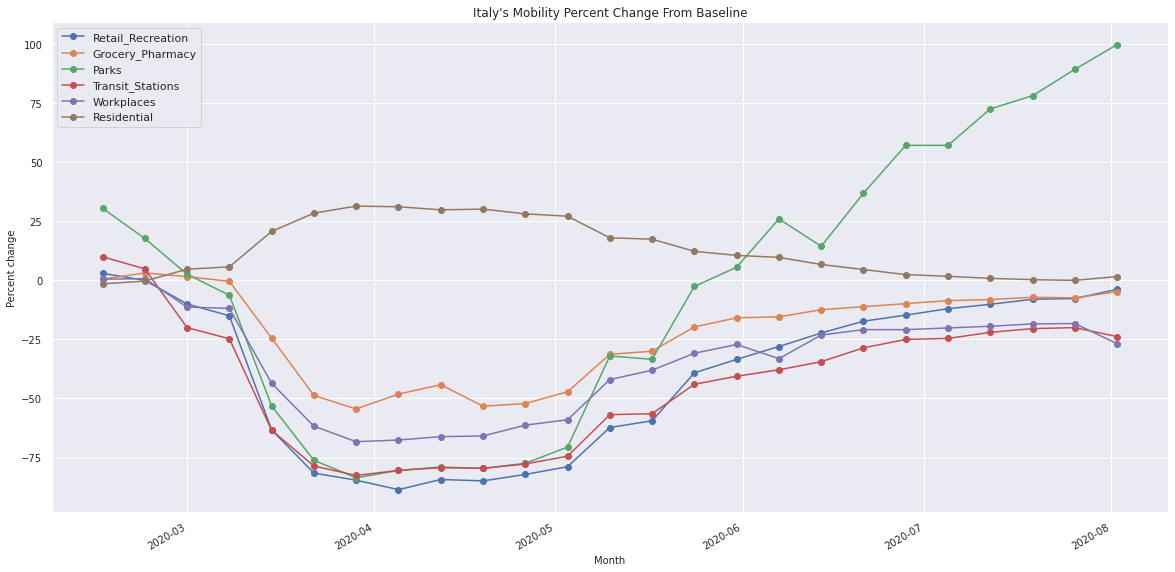

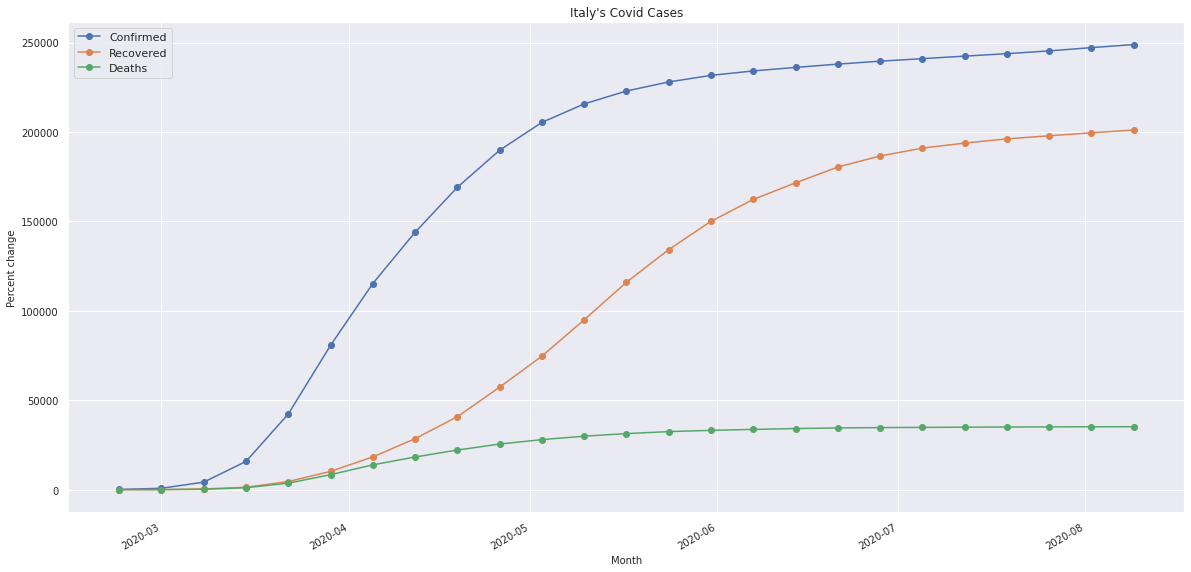

In [12]:
#North Subtropical
#Italy
mobility_data_italy = mobility_country('Italy')
covid_data_italy = covid_country('Italy', covid_data)
plotter(mobility_data_italy, "Italy's Mobility Percent Change From Baseline")
plotter(covid_data_italy, "Italy's Covid Cases")

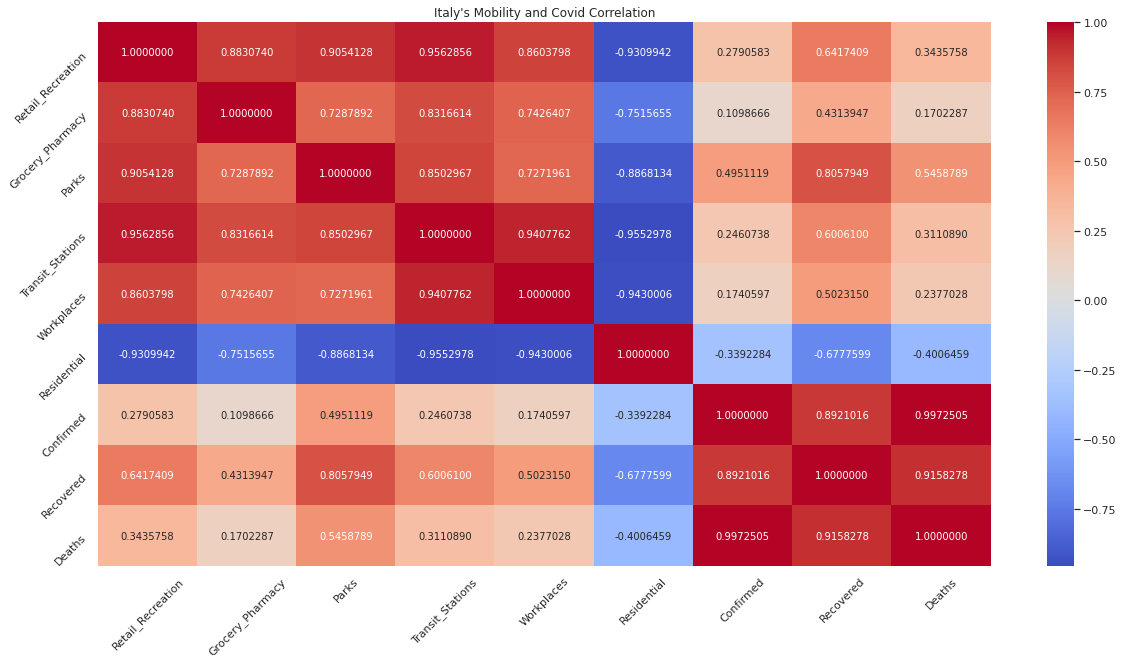

In [13]:
correlation(mobility_data_italy, covid_data_italy, "Italy's Mobility and Covid Correlation")

In [ ]:
#North Subtropical
#Germany
mobility_data_germany = mobility_country('Germany')
covid_data_germany = covid_country('Germany', covid_data)
plotter(mobility_data_germany, "Germany's Mobility Percent Change From Baseline")
plotter(covid_data_germany, "Germany's Covid Cases")

In [ ]:
correlation(mobility_data_germany, covid_data_germany, "Germany's Mobility and Covid Correlation")

In [ ]:
#North Subtropical
#Spain
mobility_data_spain = mobility_country('Spain')
covid_data_spain = covid_country('Spain', covid_data)
plotter(mobility_data_spain, "Spain's Mobility Percent Change From Baseline")
plotter(covid_data_spain, "Spain's Covid Cases")

In [ ]:
correlation(mobility_data_spain, covid_data_spain, "Spain's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15          Japan          NaN  ...        4.0         0.0
2020-02-16          Japan          NaN  ...       -2.0         2.0
2020-02-17          Japan          NaN  ...        0.0         1.0
2020-02-18          Japan          NaN  ...        0.0         1.0
2020-02-19          Japan          NaN  ...        0.0         0.0
...                   ...          ...  ...        ...         ...
2020-07-27          Japan          NaN  ...      -11.0         6.0
2020-07-28          Japan          NaN  ...      -12.0         7.0
2020-07-29          Japan          NaN  ...      -12.0         6.0
2020-07-30          Japan          NaN  ...      -12.0         6.0
2020-07-31          Japan          NaN  ...      -12.0         7.0

[168 rows x 10 columns]


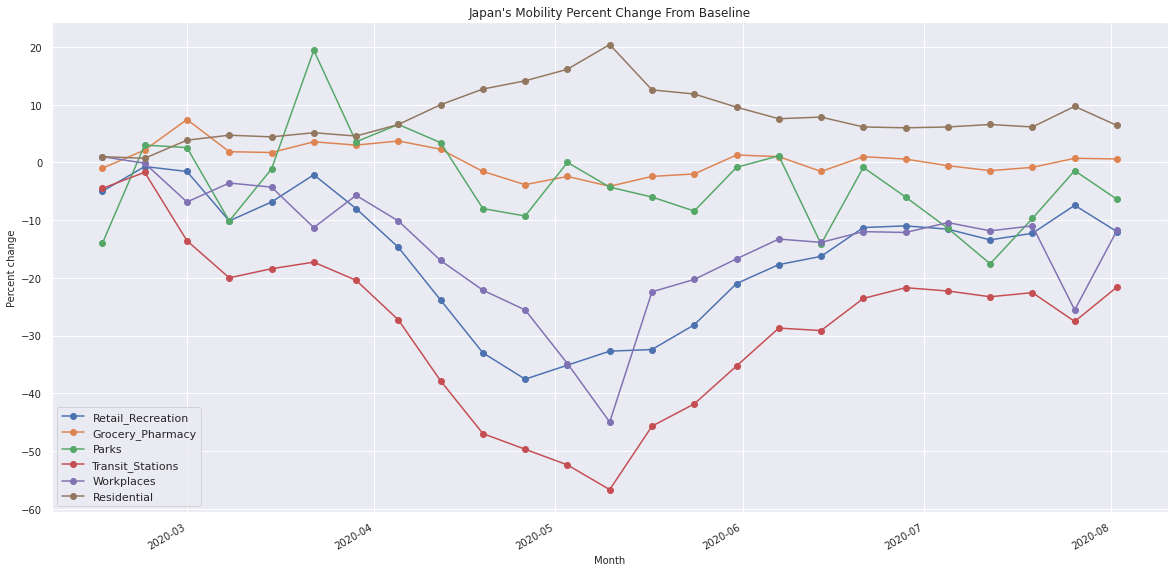

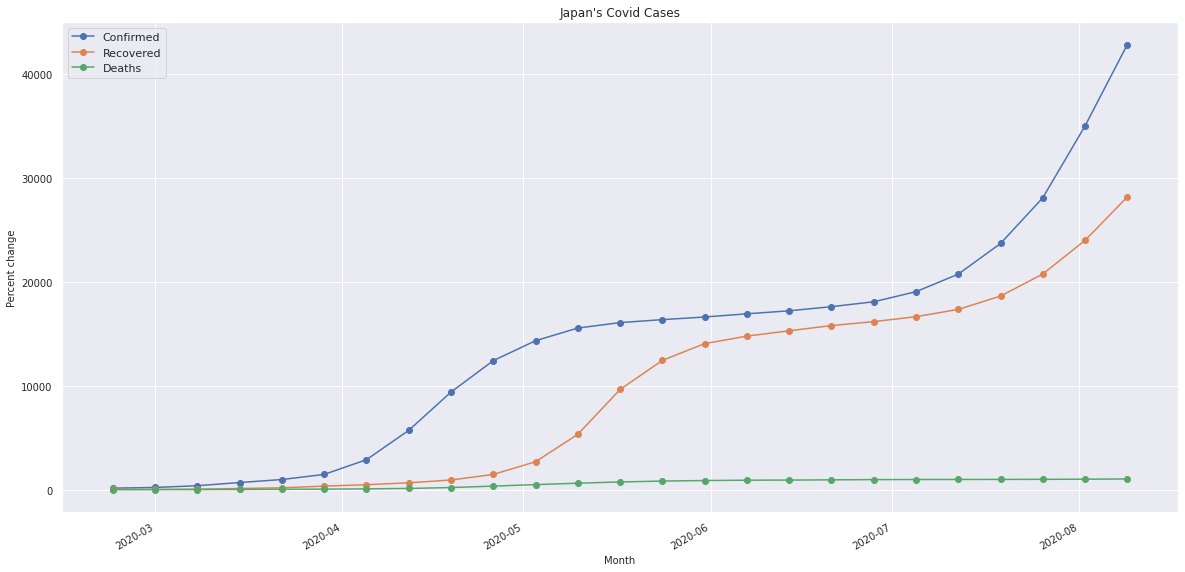

In [14]:
#North Subtropical
#Japan
mobility_data_japan = mobility_country('Japan')
covid_data_japan = covid_country('Japan', covid_data)
plotter(mobility_data_japan, "Japan's Mobility Percent Change From Baseline")
plotter(covid_data_japan, "Japan's Covid Cases")

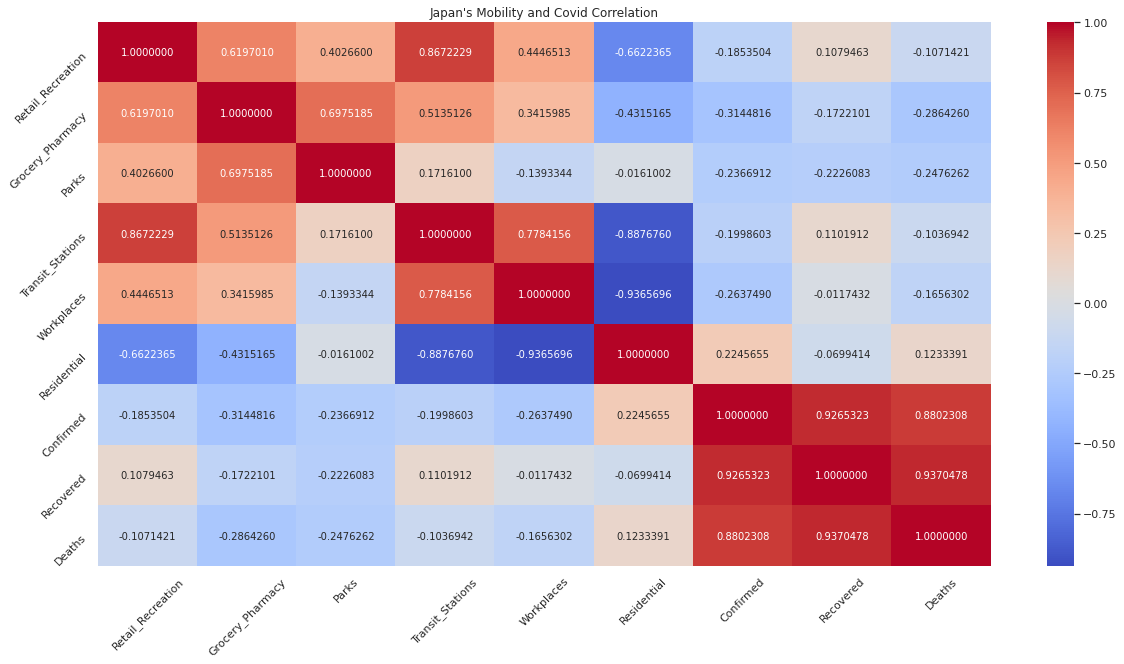

In [15]:
correlation(mobility_data_japan, covid_data_japan, "Japan's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15          India          NaN  ...        5.0         0.0
2020-02-16          India          NaN  ...        0.0         0.0
2020-02-17          India          NaN  ...        4.0         0.0
2020-02-18          India          NaN  ...        3.0         0.0
2020-02-19          India          NaN  ...        4.0         1.0
...                   ...          ...  ...        ...         ...
2020-07-27          India          NaN  ...      -33.0        16.0
2020-07-28          India          NaN  ...      -35.0        16.0
2020-07-29          India          NaN  ...      -35.0        16.0
2020-07-30          India          NaN  ...      -33.0        15.0
2020-07-31          India          NaN  ...      -34.0        16.0

[168 rows x 10 columns]


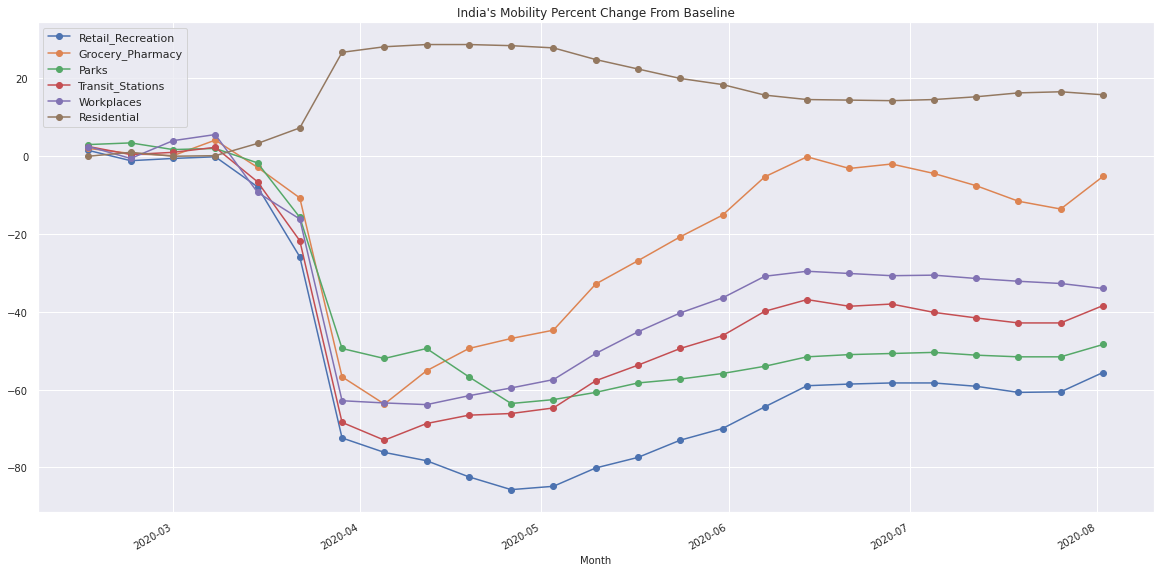

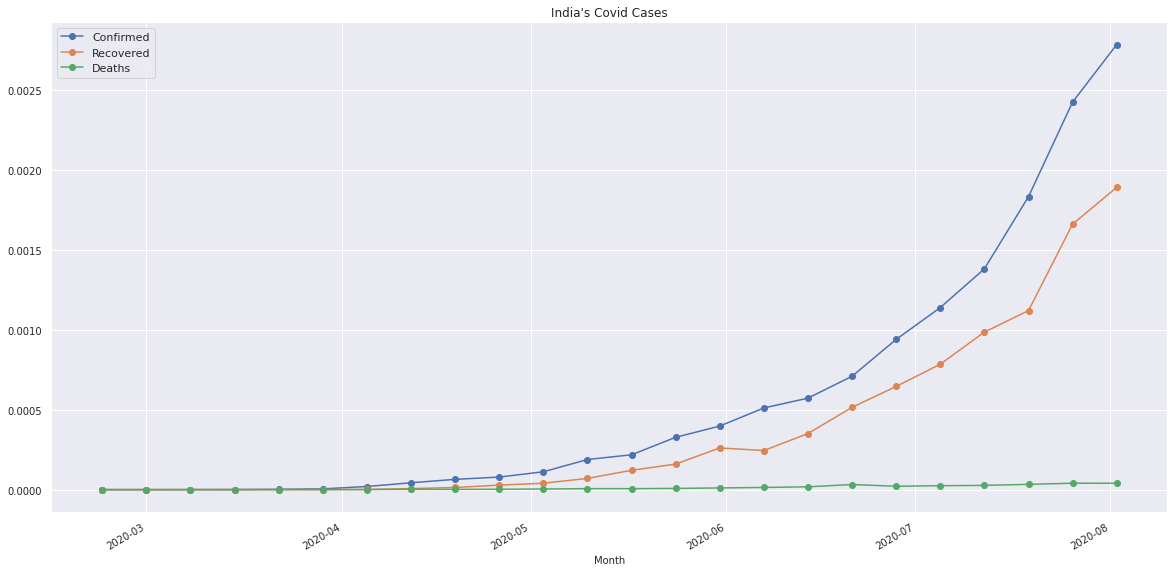

In [ ]:
#Tropical
#India
mobility_data_india = mobility_country('India')
covid_data_india = covid_country('India', covid_data)
plotter(mobility_data_india, "India's Mobility Percent Change From Baseline")
plotter(covid_data_india, "India's Covid Cases")

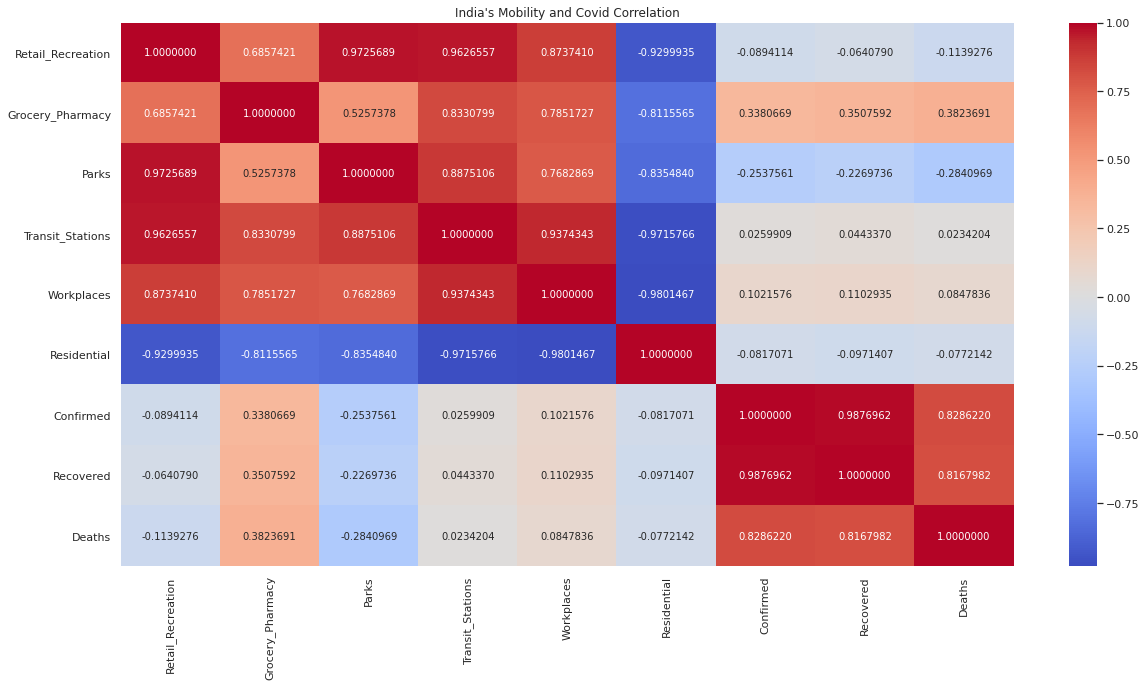

In [ ]:
correlation(mobility_data_india, covid_data_india, "India's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15         Brazil          NaN  ...        6.0         0.0
2020-02-16         Brazil          NaN  ...        0.0         1.0
2020-02-17         Brazil          NaN  ...       19.0        -1.0
2020-02-18         Brazil          NaN  ...       15.0        -1.0
2020-02-19         Brazil          NaN  ...       14.0        -1.0
...                   ...          ...  ...        ...         ...
2020-07-27         Brazil          NaN  ...      -16.0        12.0
2020-07-28         Brazil          NaN  ...      -19.0        12.0
2020-07-29         Brazil          NaN  ...      -19.0        13.0
2020-07-30         Brazil          NaN  ...      -19.0        13.0
2020-07-31         Brazil          NaN  ...      -15.0        12.0

[168 rows x 10 columns]


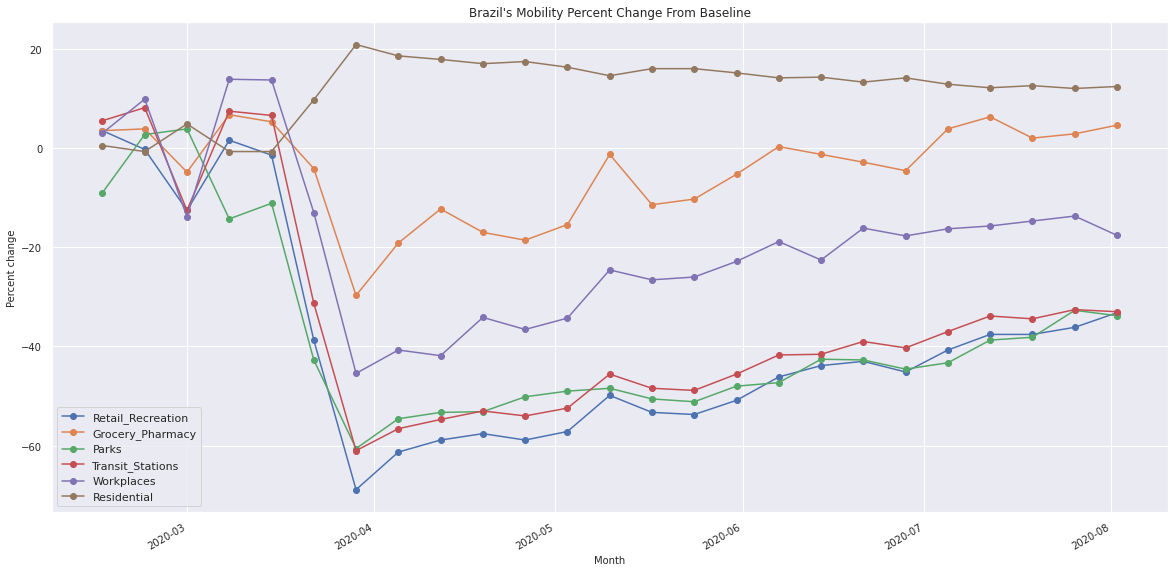

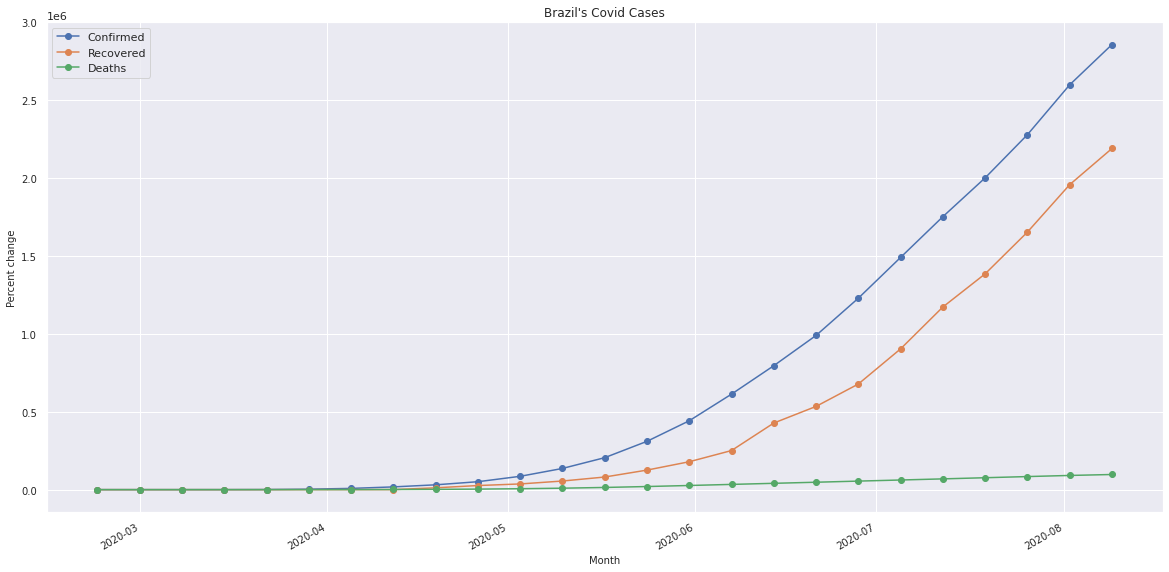

In [16]:
#Tropical
#Brazil
mobility_data_brazil = mobility_country('Brazil')
covid_data_brazil = covid_country('Brazil', covid_data)
plotter(mobility_data_brazil, "Brazil's Mobility Percent Change From Baseline")
plotter(covid_data_brazil, "Brazil's Covid Cases")

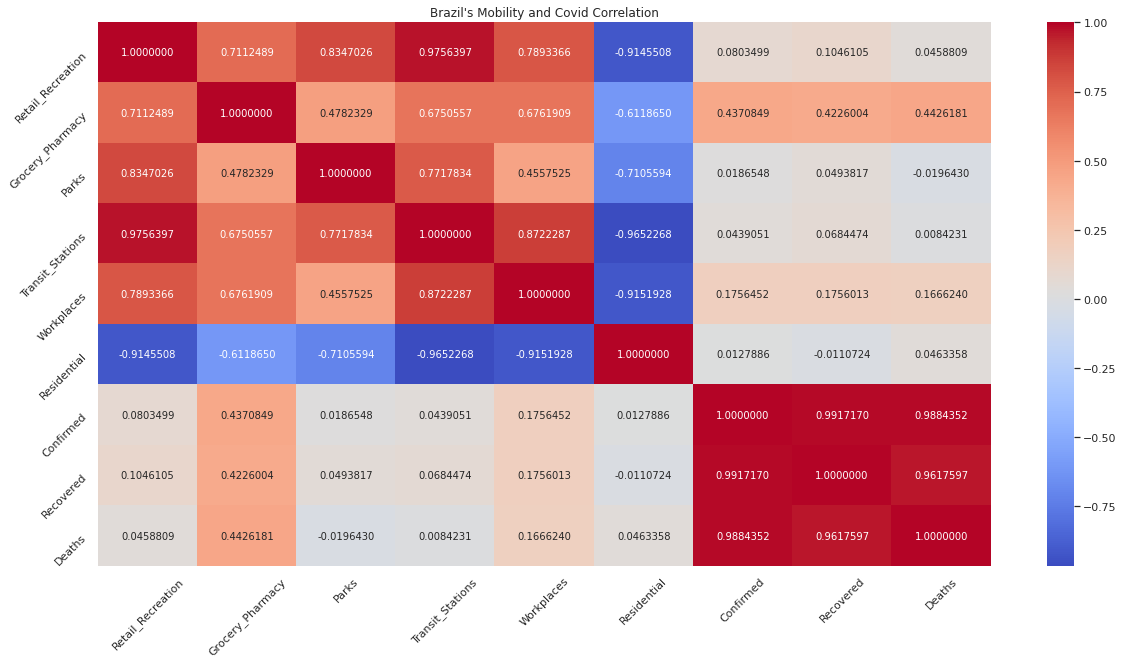

In [17]:
correlation(mobility_data_brazil, covid_data_brazil, "Brazil's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15         Taiwan          NaN  ...       56.0        -1.0
2020-02-16         Taiwan          NaN  ...       -8.0         5.0
2020-02-17         Taiwan          NaN  ...       -3.0         6.0
2020-02-18         Taiwan          NaN  ...        2.0         5.0
2020-02-19         Taiwan          NaN  ...        3.0         4.0
...                   ...          ...  ...        ...         ...
2020-07-27         Taiwan          NaN  ...       -8.0         3.0
2020-07-28         Taiwan          NaN  ...       -4.0         3.0
2020-07-29         Taiwan          NaN  ...       -4.0         2.0
2020-07-30         Taiwan          NaN  ...       -6.0        -1.0
2020-07-31         Taiwan          NaN  ...       -9.0         3.0

[168 rows x 10 columns]


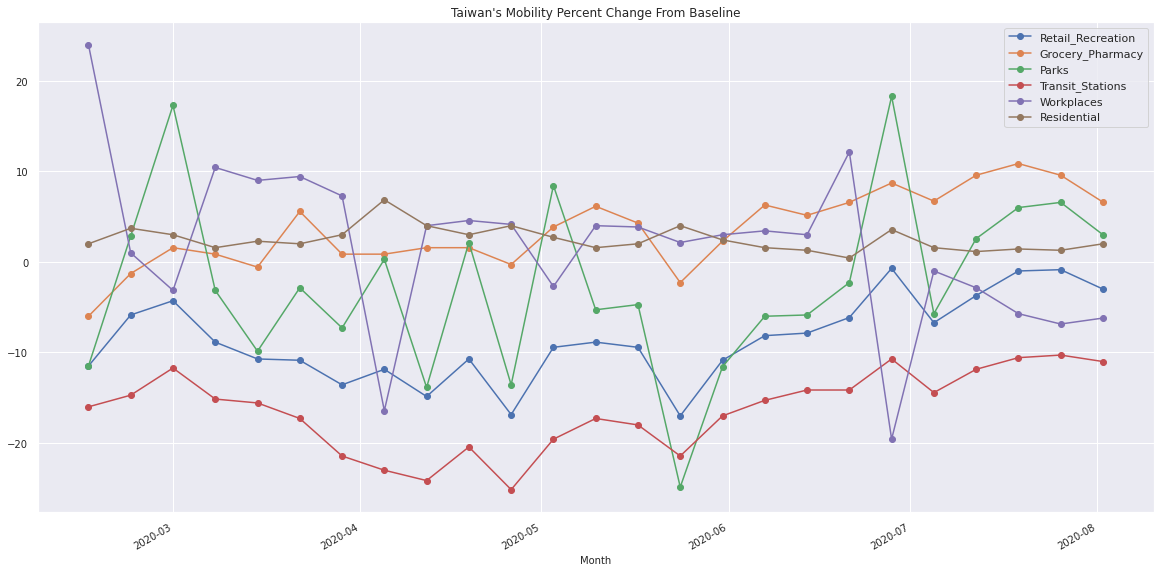

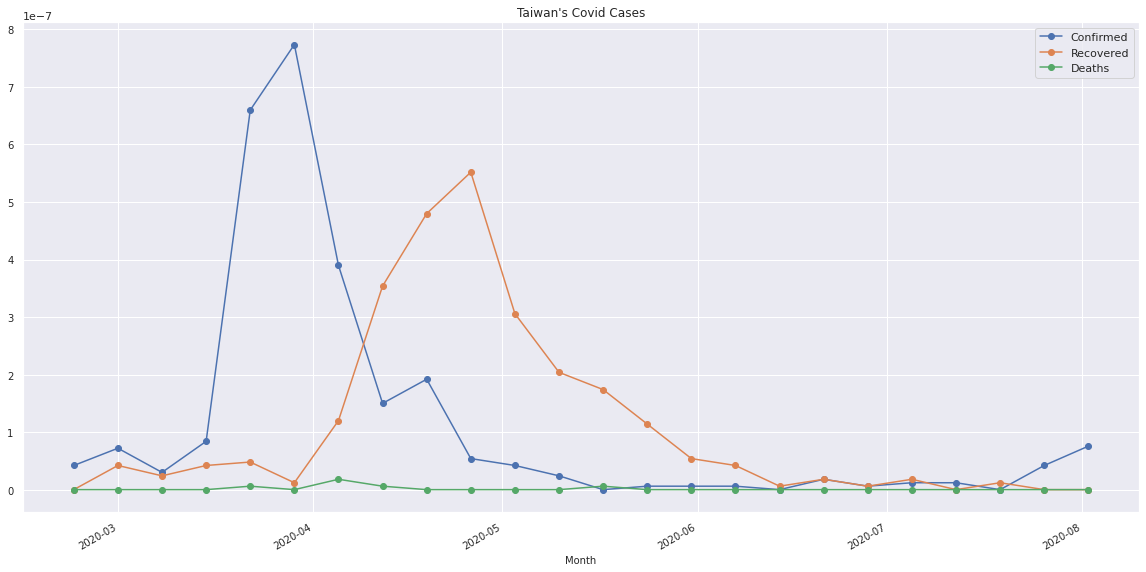

In [ ]:
#Tropical
#Taiwan
mobility_data_taiwan = mobility_country('Taiwan')
covid_data_taiwan = covid_country('Taiwan', covid_data)
plotter(mobility_data_taiwan, "Taiwan's Mobility Percent Change From Baseline")
plotter(covid_data_taiwan, "Taiwan's Covid Cases")

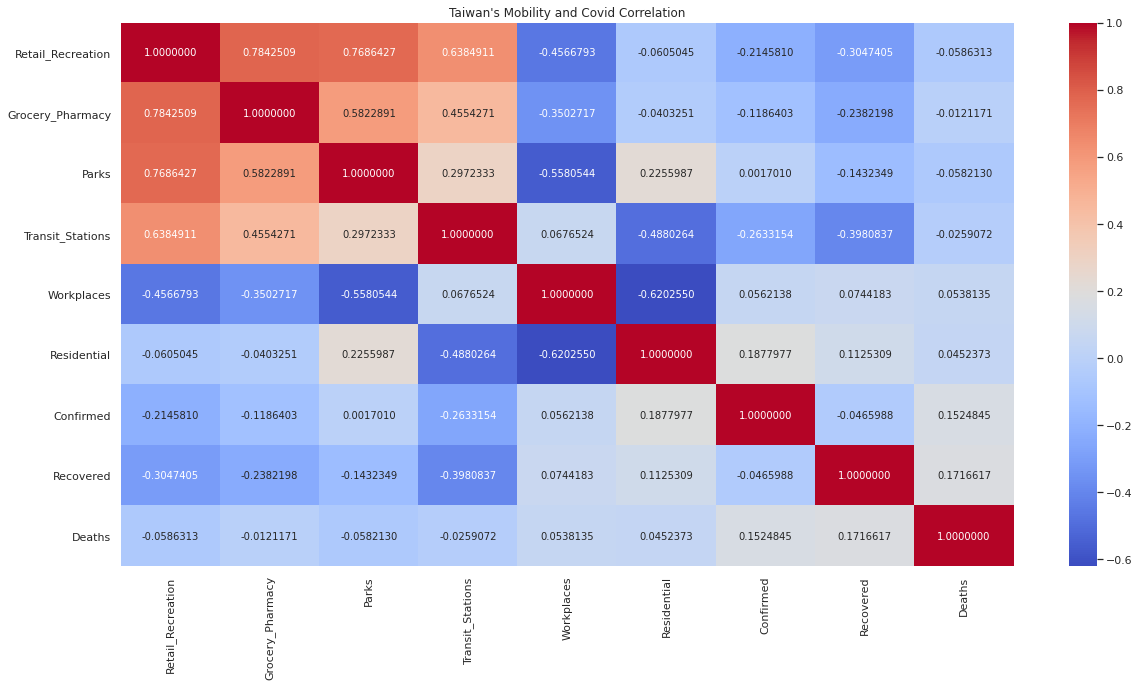

In [ ]:
correlation(mobility_data_taiwan, covid_data_taiwan, "Taiwan's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15   Saudi Arabia          NaN  ...        0.0         2.0
2020-02-16   Saudi Arabia          NaN  ...        4.0         2.0
2020-02-17   Saudi Arabia          NaN  ...        4.0         2.0
2020-02-18   Saudi Arabia          NaN  ...        4.0         2.0
2020-02-19   Saudi Arabia          NaN  ...        3.0         1.0
...                   ...          ...  ...        ...         ...
2020-07-27   Saudi Arabia          NaN  ...      -30.0         9.0
2020-07-28   Saudi Arabia          NaN  ...      -30.0         9.0
2020-07-29   Saudi Arabia          NaN  ...      -34.0         9.0
2020-07-30   Saudi Arabia          NaN  ...      -57.0        21.0
2020-07-31   Saudi Arabia          NaN  ...      -21.0         8.0

[168 rows x 10 columns]


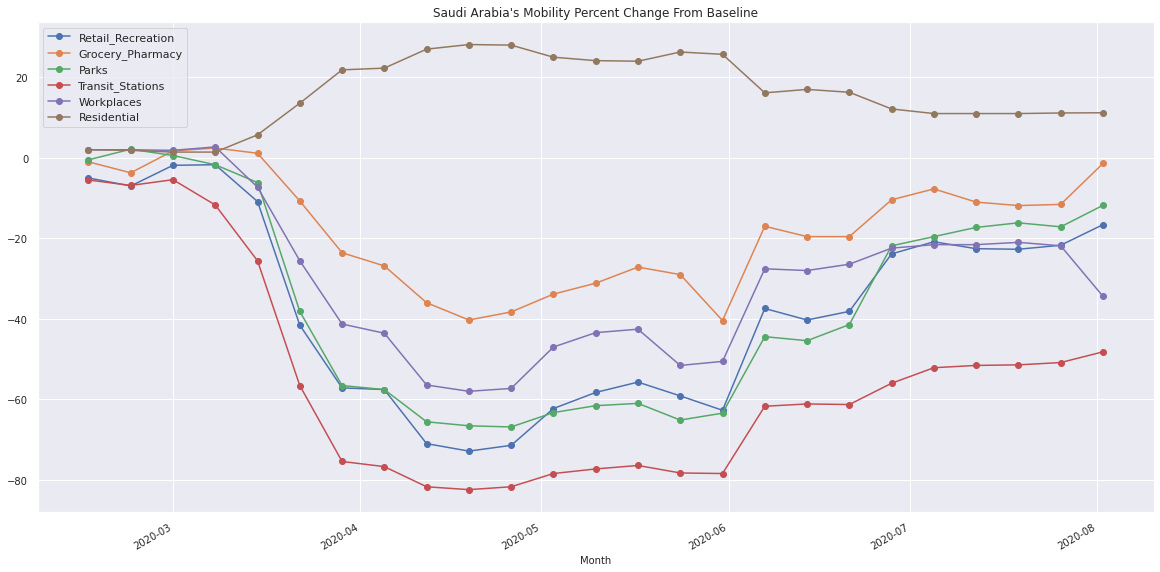

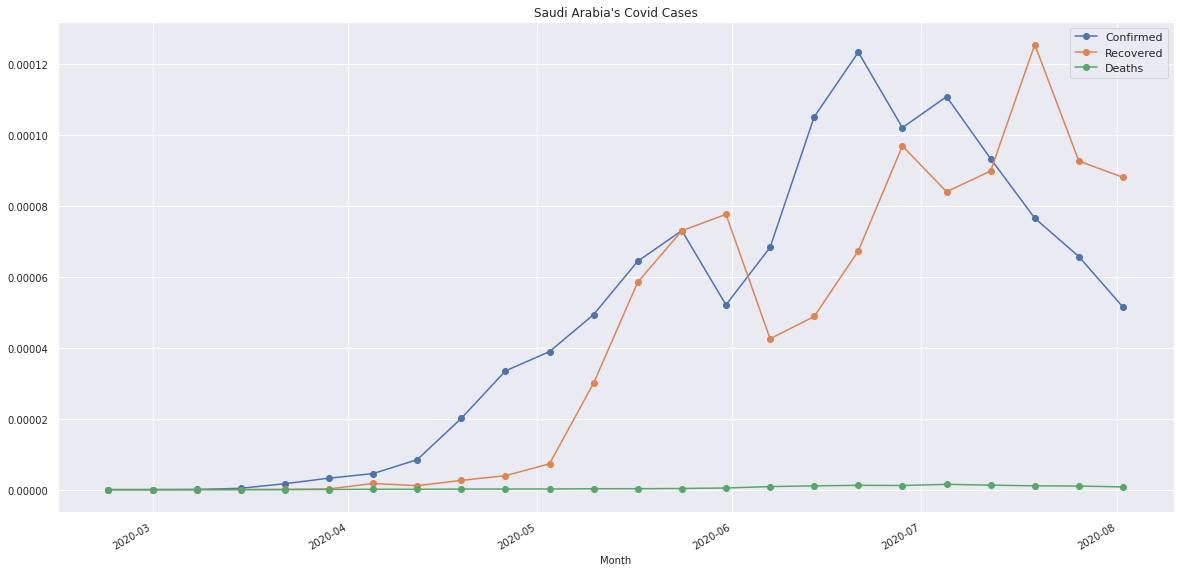

In [ ]:
#Tropical
#Saudi Arabia
mobility_data_saudiarabia = mobility_country('Saudi Arabia')
covid_data_saudiarabia = covid_country('Saudi Arabia', covid_data)
plotter(mobility_data_saudiarabia, "Saudi Arabia's Mobility Percent Change From Baseline")
plotter(covid_data_saudiarabia, "Saudi Arabia's Covid Cases")

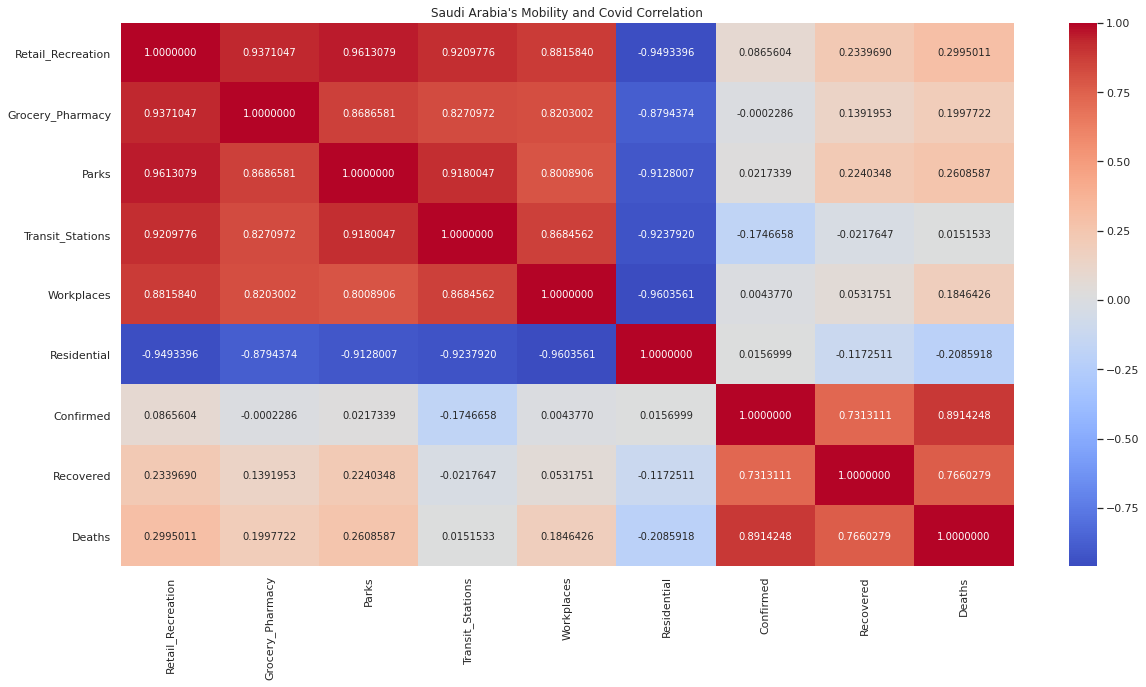

In [ ]:
correlation(mobility_data_saudiarabia, covid_data_saudiarabia, "Saudi Arabia's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15       Thailand          NaN  ...        7.0         1.0
2020-02-16       Thailand          NaN  ...        2.0         2.0
2020-02-17       Thailand          NaN  ...        2.0         1.0
2020-02-18       Thailand          NaN  ...        0.0         2.0
2020-02-19       Thailand          NaN  ...        0.0         1.0
...                   ...          ...  ...        ...         ...
2020-07-27       Thailand          NaN  ...      -55.0        11.0
2020-07-28       Thailand          NaN  ...      -58.0        13.0
2020-07-29       Thailand          NaN  ...      -15.0         4.0
2020-07-30       Thailand          NaN  ...      -14.0         4.0
2020-07-31       Thailand          NaN  ...      -15.0         5.0

[168 rows x 10 columns]


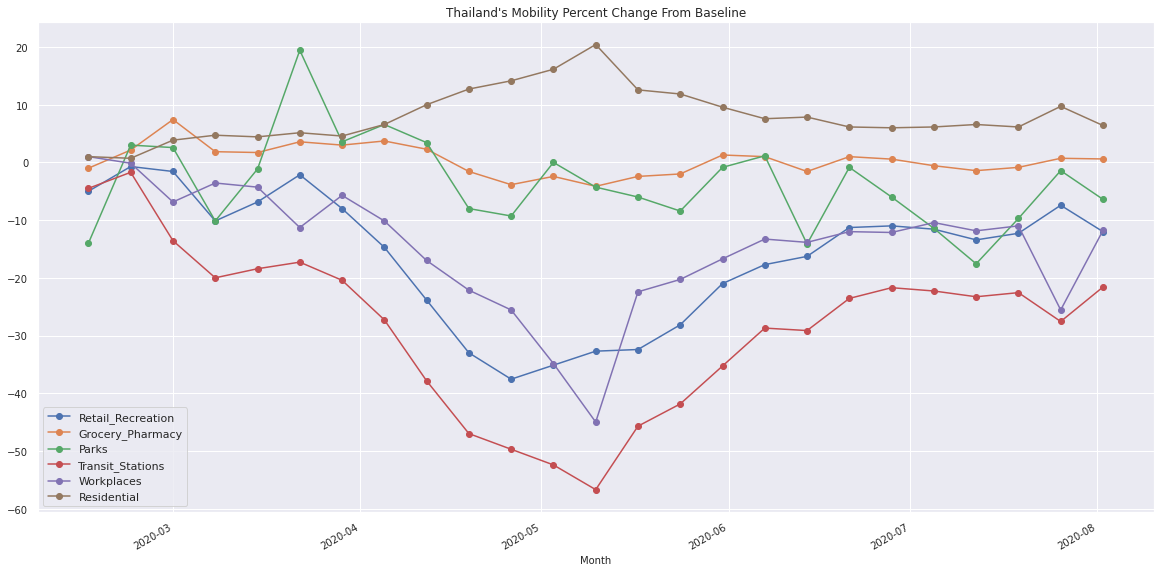

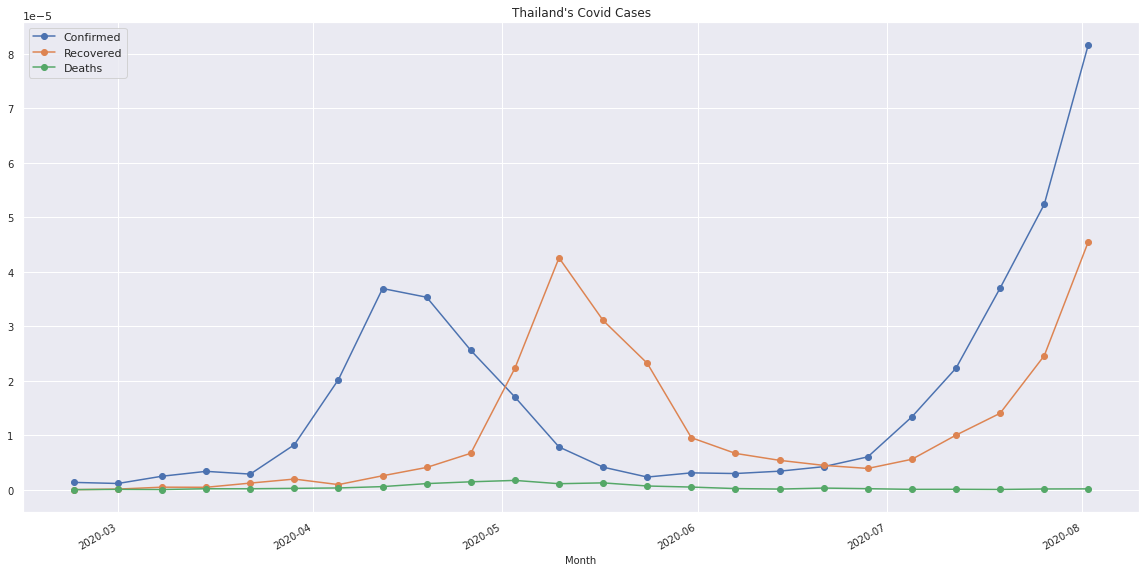

In [ ]:
#Tropical
#Thailand
mobility_data_thailand = mobility_country('Thailand')
covid_data_thailand = covid_country('Thailand', covid_data)
plotter(mobility_data_japan, "Thailand's Mobility Percent Change From Baseline")
plotter(covid_data_japan, "Thailand's Covid Cases")

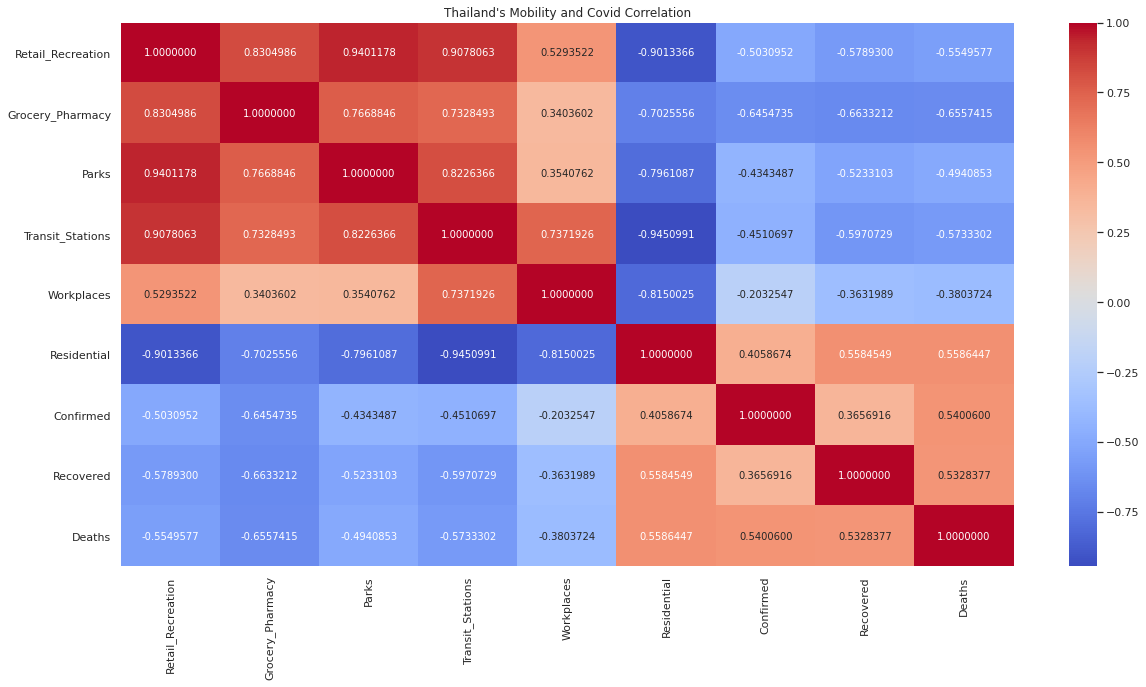

In [ ]:
correlation(mobility_data_thailand, covid_data_thailand, "Thailand's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15      Argentina          NaN  ...       -1.0         0.0
2020-02-16      Argentina          NaN  ...       -4.0         2.0
2020-02-17      Argentina          NaN  ...        7.0         1.0
2020-02-18      Argentina          NaN  ...        9.0        -1.0
2020-02-19      Argentina          NaN  ...       11.0        -2.0
...                   ...          ...  ...        ...         ...
2020-07-27      Argentina          NaN  ...      -25.0        16.0
2020-07-28      Argentina          NaN  ...      -26.0        15.0
2020-07-29      Argentina          NaN  ...      -25.0        15.0
2020-07-30      Argentina          NaN  ...      -26.0        17.0
2020-07-31      Argentina          NaN  ...      -24.0        17.0

[168 rows x 10 columns]


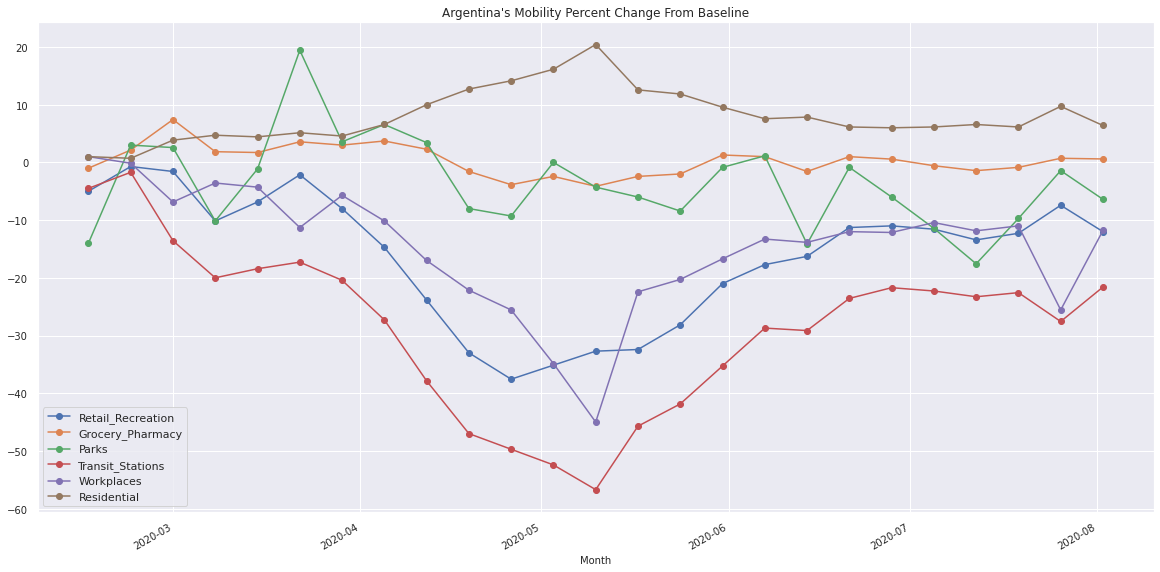

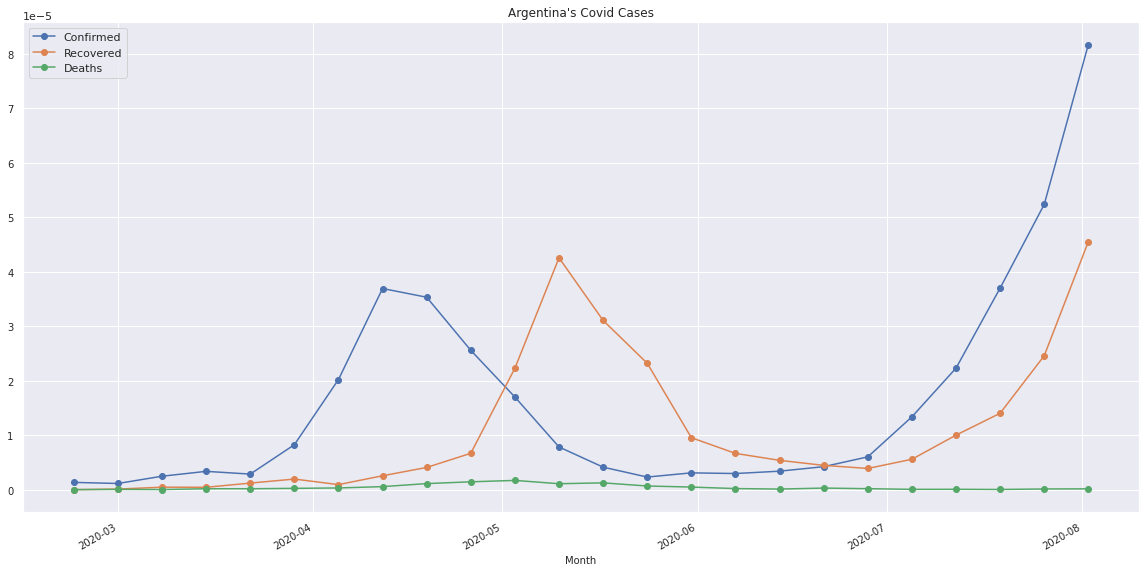

In [ ]:
#South Subtropical
#Argentina
mobility_data_argentina = mobility_country('Argentina')
covid_data_argentina = covid_country('Argentina', covid_data)
plotter(mobility_data_japan, "Argentina's Mobility Percent Change From Baseline")
plotter(covid_data_japan, "Argentina's Covid Cases")

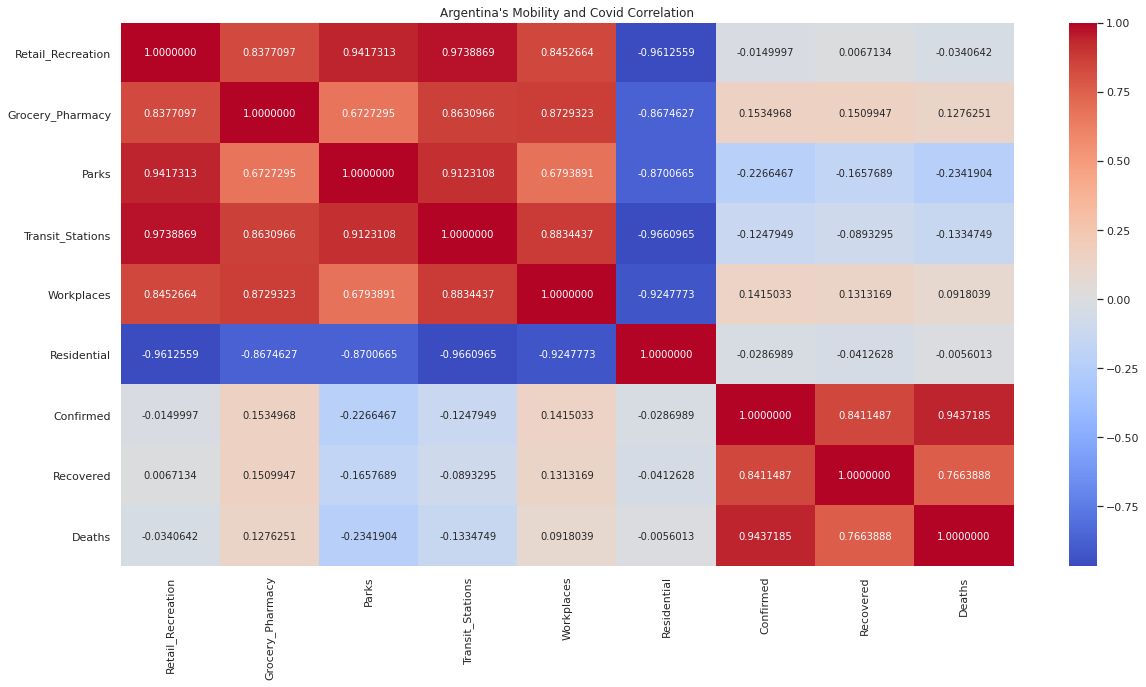

In [ ]:
correlation(mobility_data_argentina, covid_data_argentina, "Argentina's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15      Australia          NaN  ...        3.0         0.0
2020-02-16      Australia          NaN  ...       -1.0         0.0
2020-02-17      Australia          NaN  ...       17.0        -2.0
2020-02-18      Australia          NaN  ...       14.0        -1.0
2020-02-19      Australia          NaN  ...       13.0        -1.0
...                   ...          ...  ...        ...         ...
2020-07-27      Australia          NaN  ...      -17.0        10.0
2020-07-28      Australia          NaN  ...      -18.0        10.0
2020-07-29      Australia          NaN  ...      -18.0        10.0
2020-07-30      Australia          NaN  ...      -18.0        10.0
2020-07-31      Australia          NaN  ...      -17.0         9.0

[168 rows x 10 columns]


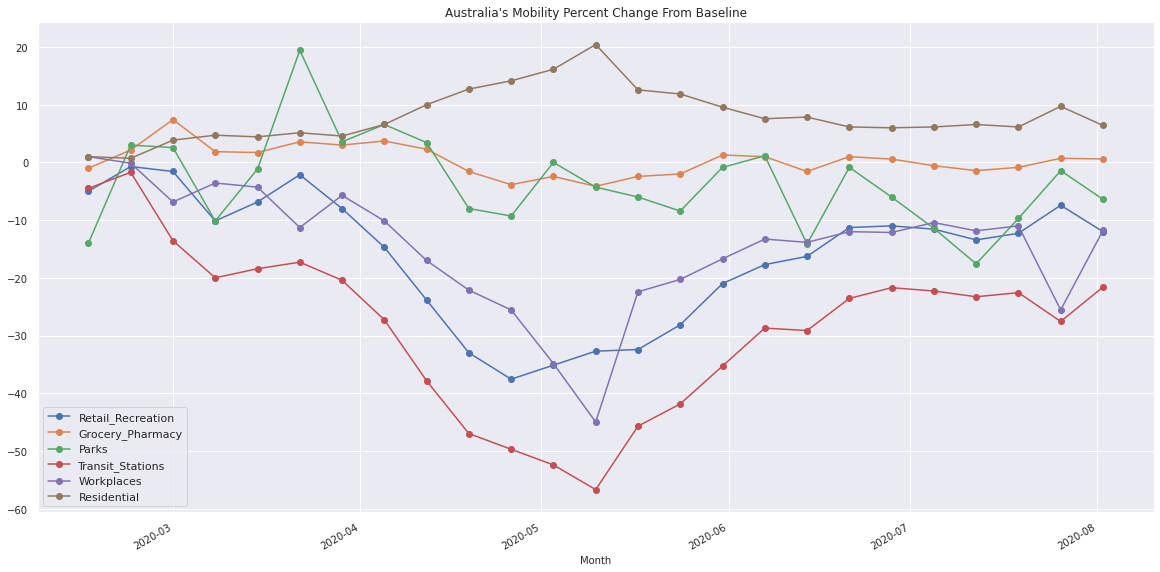

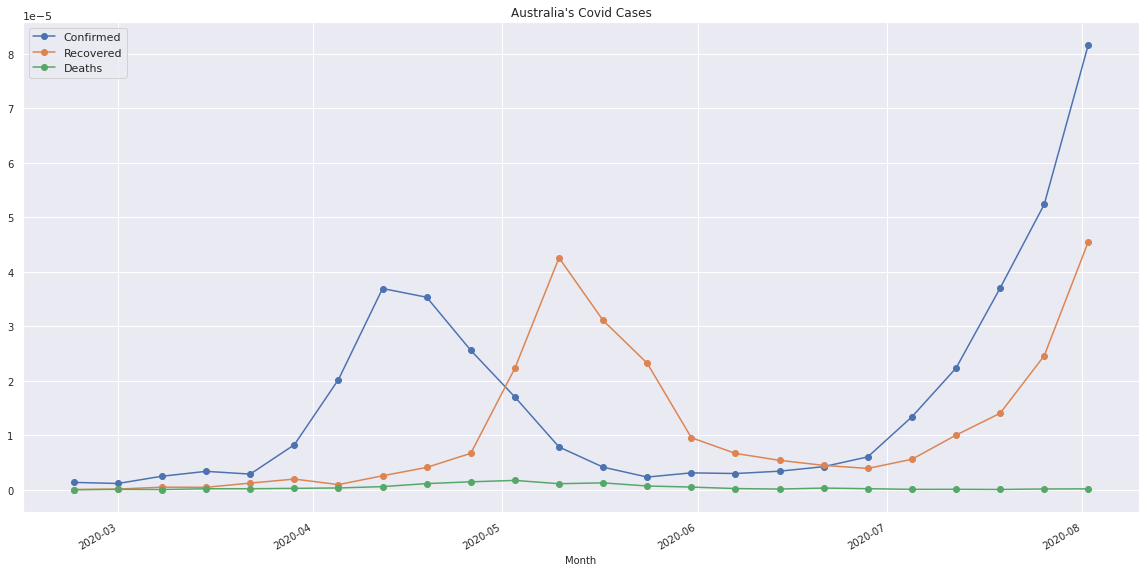

In [ ]:
#South Subtropical
#Australia
mobility_data_australia = mobility_country('Australia')
covid_data_australia = covid_country('Australia', covid_data)
plotter(mobility_data_japan, "Australia's Mobility Percent Change From Baseline")
plotter(covid_data_japan, "Australia's Covid Cases")

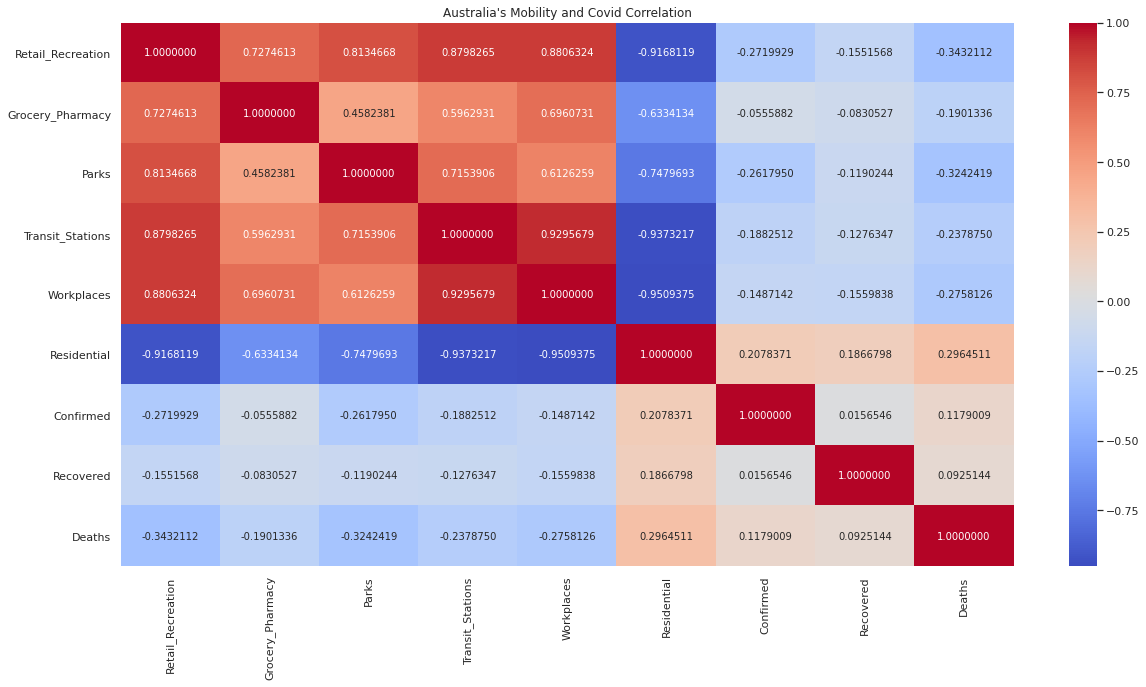

In [ ]:
correlation(mobility_data_australia, covid_data_australia, "Australia's Mobility and Covid Correlation")

           Country/Region sub_region_1  ... Workplaces Residential
Date                                    ...                       
2020-02-15          Chile          NaN  ...       -3.0         0.0
2020-02-16          Chile          NaN  ...       -1.0         0.0
2020-02-17          Chile          NaN  ...       -8.0         1.0
2020-02-18          Chile          NaN  ...       -7.0         1.0
2020-02-19          Chile          NaN  ...       -7.0         1.0
...                   ...          ...  ...        ...         ...
2020-07-27          Chile          NaN  ...      -45.0        25.0
2020-07-28          Chile          NaN  ...      -45.0        24.0
2020-07-29          Chile          NaN  ...      -44.0        24.0
2020-07-30          Chile          NaN  ...      -46.0        26.0
2020-07-31          Chile          NaN  ...      -44.0        28.0

[168 rows x 10 columns]


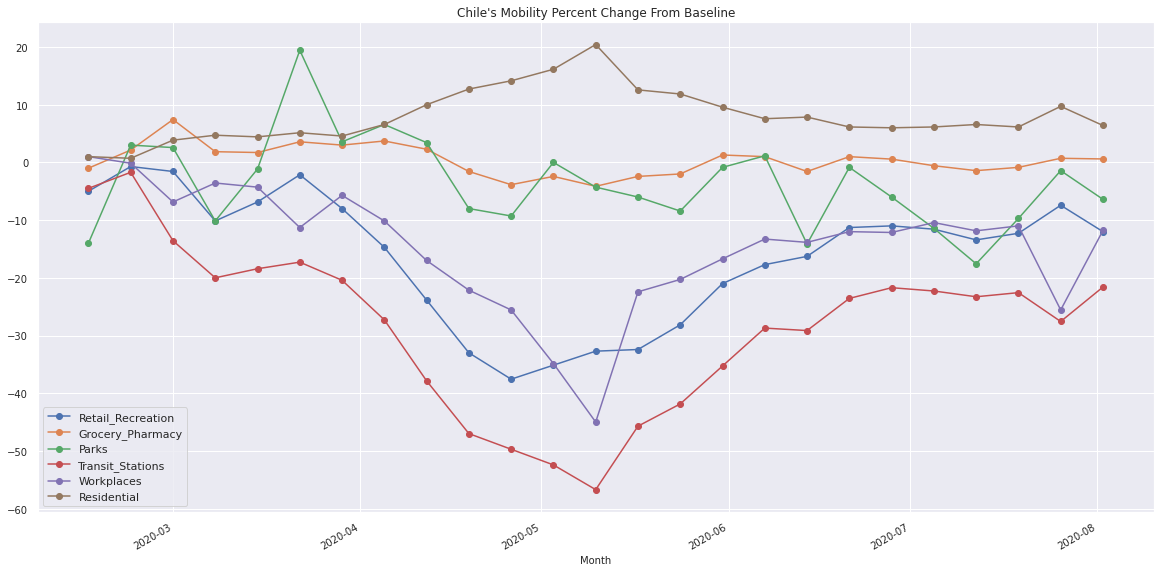

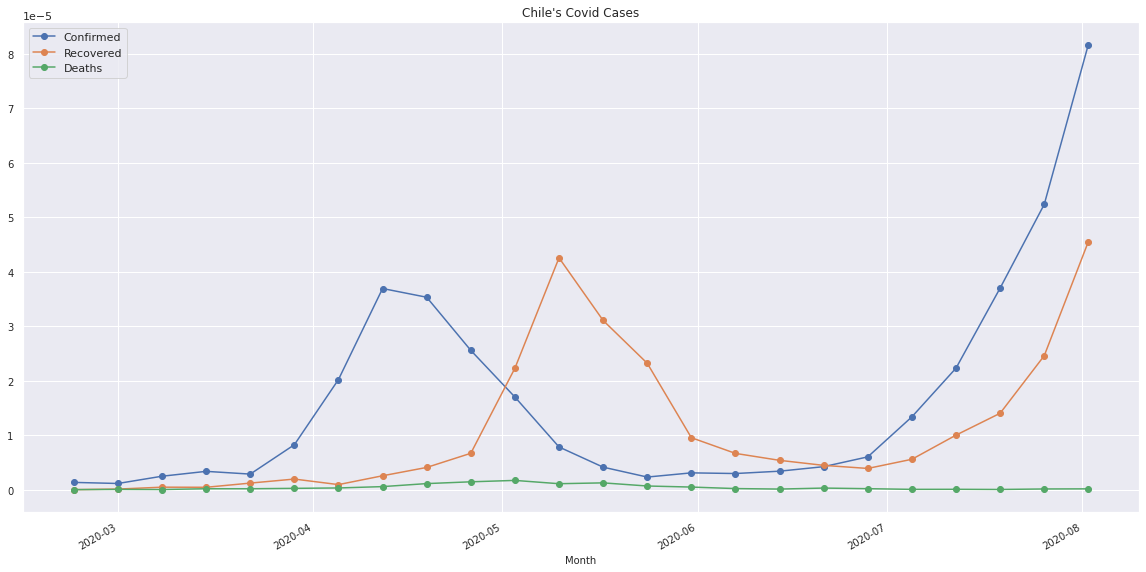

In [ ]:
#South Subtropical
#Chile
mobility_data_chile = mobility_country('Chile')
covid_data_chile = covid_country('Chile', covid_data)
plotter(mobility_data_japan, "Chile's Mobility Percent Change From Baseline")
plotter(covid_data_japan, "Chile's Covid Cases")

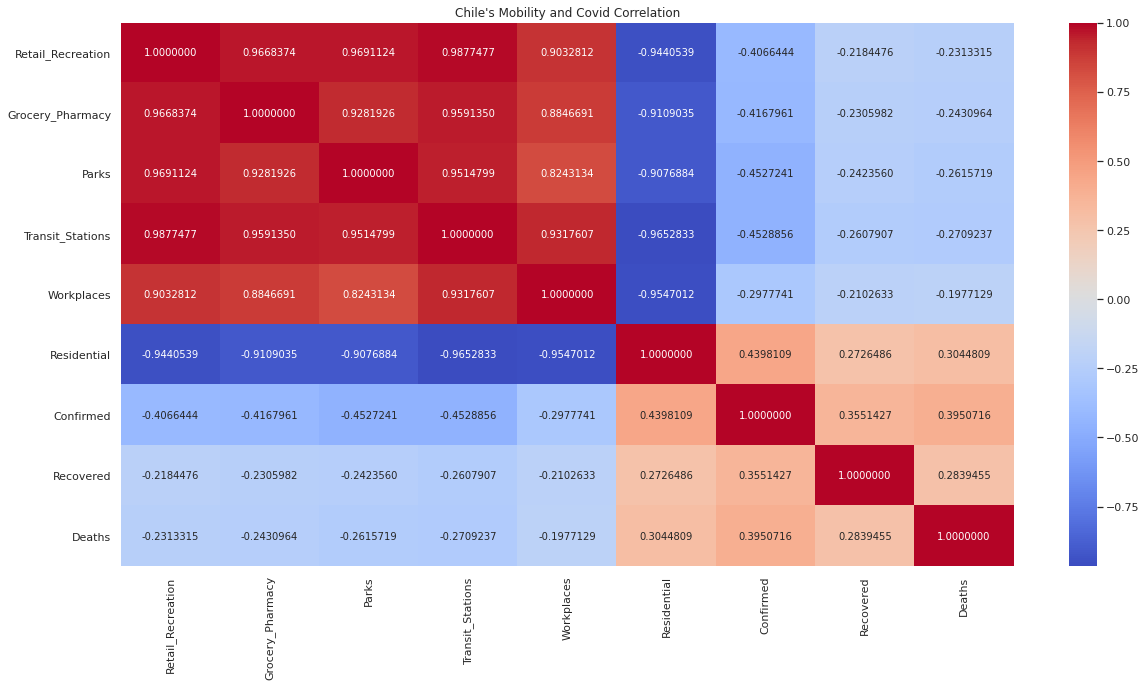

In [ ]:
correlation(mobility_data_chile, covid_data_chile, "Chile's Mobility and Covid Correlation")

In [ ]:
#South Subtropical
#New Zealand
# mobility_data_newzealand = mobility_country('New Zealand')
# covid_data_newzealand = data_covid.loc[data_covid['Country/Region']== 'New Zealand']
# plotter(mobility_data_japan, "New Zealand's Mobility Percent Change From Baseline")
# plotter(covid_data_japan, "New Zealand's Covid Cases")

In [ ]:
# correlation(mobility_data_newzealand, covid_data_newzealand, "New Zealand's Mobility and Covid Correlation")

In [ ]:
#South Subtropical
#Uruguay
# mobility_data_uruguay = mobility_country('Uruguay')
# covid_data_uruguay = data_covid.loc[data_covid['Country/Region']== 'Uruguay']
# plotter(mobility_data_japan, "Uruguay's Mobility Percent Change From Baseline")
# plotter(covid_data_japan, "Uruguay's Covid Cases")

In [ ]:
# correlation(mobility_data_uruguay, covid_data_uruguay, "Uruguay's Mobility and Covid Correlation")

In [ ]:
# !streamlit run Mobility